# Counterfactual Ellipse Generation

In this example, I will showcase how to use normalizing flow to learn the distribution of random variables that generates ellipses. Ellipse can be defined as a set of points $V=(v_0,v_1)$ that satisfies the following equation:


\begin{align*}
V_0 &\coloneqq U_0\sin(x) \\
V_1 &\coloneqq U_1\cos(x) \\
\end{align*}

where $x \in [0, 2\pi]$ which represents the angle of the point $V$ from the origin $O$, and $U_0, U_1$ are the parameters that controls the size of the ellipse. Let's see how this looks like in the following code:

The point on the ellipse is (2.1213203436, 0.7071067812).


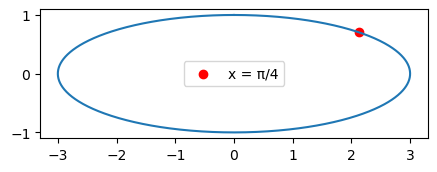

This ellipse has the semi-major/minor axes length of U_0 and U_1.


In [21]:
import numpy as np
import matplotlib.pyplot as plt

U0, U1 = 3.0, 1.0  # semi-major and semi-minor axes

X = np.linspace(0, 2*np.pi, 1000)  # parameter

V0 = U0 * np.sin(X)
V1 = U1 * np.cos(X)

x_point = np.pi/4  # x-coordinate where we want to visualize the point
y_point = U1 * np.cos(x_point)  # corresponding y-coordinate on the ellipse

plt.figure(figsize=(5, 5))
plt.plot(V0, V1)
plt.scatter(U0 * np.sin(x_point), y_point, color='red', label='x = π/4')
print("The point on the ellipse is ({:.10f}, {:.10f}).".format(U0 * np.sin(x_point), y_point))
plt.gca().set_aspect('equal', adjustable='box')  # make sure the ellipse is not distorted
plt.legend()
plt.show()

print("This ellipse has the semi-major/minor axes length of U_0 and U_1.")

* Note that the red-dot is $(\frac{3\sqrt{2}}{2}, \frac{\sqrt{2}}{2})$ when $x=\frac{\pi}{4}$.

Now, we're interested in modeling a system that we can estimate ***counterfactual queries*** $V_{x^{\prime}} \mid\{X=x, V=(v_0, v_1)\}$, for $x^{\prime} \in(0,2 \pi)$. This query can be read as, "what would be the value of $V$ if we were to change the value of $X$ to $x^{\prime}$, given that the value of $V$ is $(v_0, v_1)$ and the value of $X$ is $x$?". Since when we observe an angle $x$ with correponding point $(v_0, v_1)$ which are not residing in the semi-major/minor axes, we can infer the size of the ellipse parameterized by $U_0$ and $U_1$, so we can use these information to estimate the counterfactual query - to draw the entire ellipse.

# Data Generation: Markovian Case

Distributions of random variables are defined as follows:

\begin{align*}
X &\coloneqq \epsilon_x \mod 2\pi, \text{ } \epsilon_x \sim \operatorname{N}(0,1)\\
U_0  &\coloneqq 1 +\epsilon_{u_0}, \text{ } \epsilon_{u_0} \sim \mathcal{N}(0,1) \\
U_1  &\coloneqq U_0 \left(1+\epsilon_{u_1}\right), \text{ } \epsilon_{u_1} \sim \mathcal{N}(0,1) \\
V_0 &\coloneqq U_0\sin(X), \text{ } \\
V_1 &\coloneqq U_1\cos(X) \text{ } \\
\end{align*}

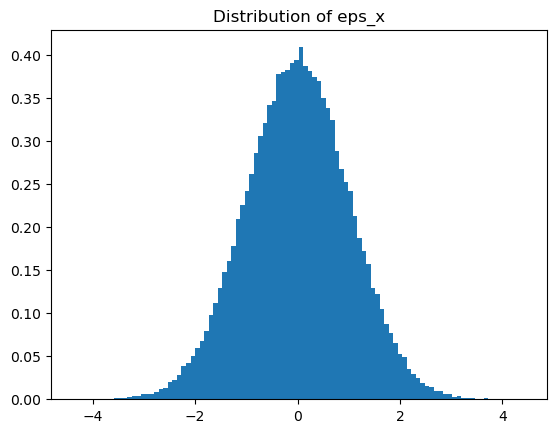

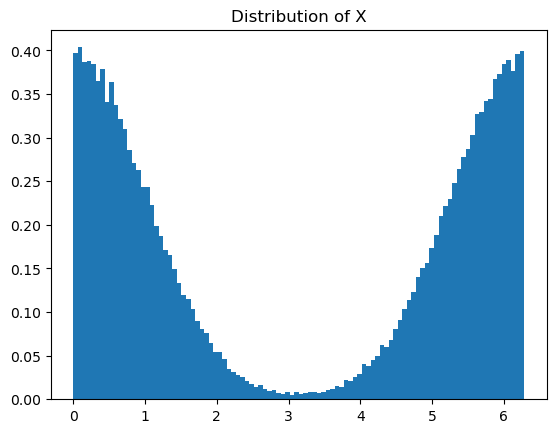

In [8]:
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
import numpy as np

eps_x_distribution = dist.Normal(torch.zeros(1), torch.ones(1))

# Generate 10000 samples from the normal distribution
epsilon_x = eps_x_distribution.sample(torch.Size([100000]))

# Generate observations of X with ground-truth mechanism
X = epsilon_x % (2 * np.pi)

# Plot histogram
plt.hist(epsilon_x.numpy(), bins=100, density=True)
plt.title('Distribution of eps_x')
plt.show()

plt.hist(X.numpy(), bins=100, density=True)
plt.title('Distribution of X')
plt.show()


Now let's see whether we can model this transformation of random variable $\epsilon_x$ to $X$ which involves $mod$ operation using normalizing flow.

/var/folders/d7/661_pryx1zx9ctp4z8417_d80000gn/T/ipykernel_87014/1063385726.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float).unsqueeze(-1) # X is output of modulo operation


step: 0, loss: 6.316585540771484
step: 200, loss: 1.835567831993103
step: 400, loss: 1.6513142585754395
step: 600, loss: 1.6037408113479614
step: 800, loss: 1.579545259475708
step: 1000, loss: 1.5577937364578247
step: 1200, loss: 1.552931547164917
step: 1400, loss: 1.5400500297546387
step: 1600, loss: 1.5351802110671997
step: 1800, loss: 1.534067988395691


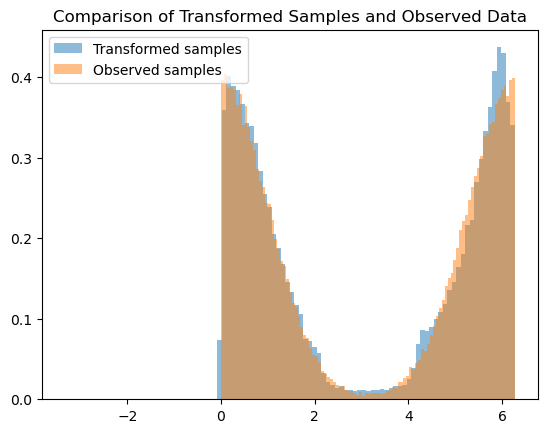

In [9]:
import pyro.distributions.transforms as T

spline_transform = T.spline(input_dim=1, 
                            count_bins=16,
                            bound=2*np.pi, # this is important to understand a priori what is the bound of X which is [0, 2pi ~ 6.28] 
                            order='quadratic') # this transform doesn't work

flow_dist = dist.TransformedDistribution(eps_x_distribution, [spline_transform])

steps = 2000

X = torch.tensor(X, dtype=torch.float).unsqueeze(-1) # X is output of modulo operation
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2) # spline transform from T.Spline

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(X).mean() # nll
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


# Apply the learned spline transform to the samples
X_transformed = spline_transform(epsilon_x.unsqueeze(-1))

# Plot the transformed samples
plt.hist(X_transformed.detach().numpy().squeeze(), bins=100, density=True, alpha=0.5, label='Transformed samples')

# Plot the actual observed data
plt.hist(X.detach().numpy().squeeze(), bins=100, density=True, alpha=0.5, label='Observed samples')

plt.title('Comparison of Transformed Samples and Observed Data')
plt.legend()
plt.show()

Let's do similar for the mechanism of $U_0  \coloneqq 1 +\epsilon_{u_0}, \text{ } \epsilon_{u_0} \sim \mathcal{N}(0,1)$

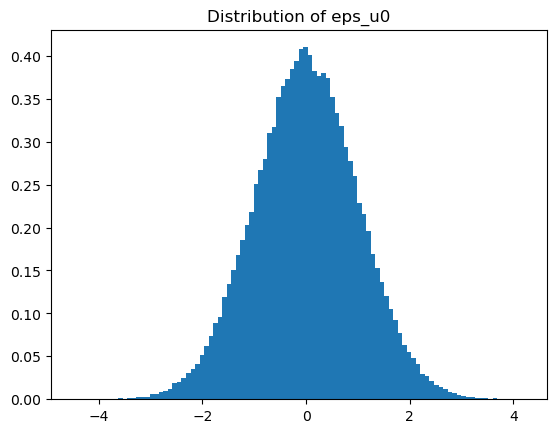

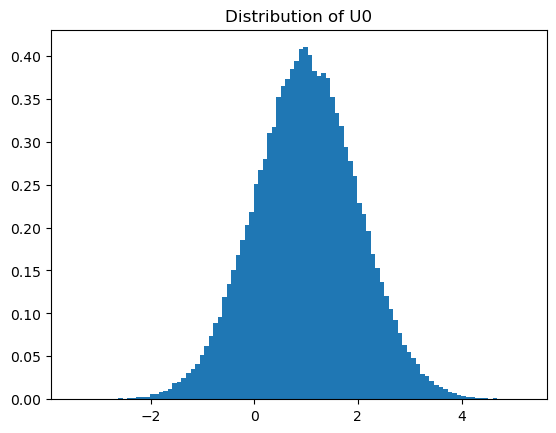

In [10]:
eps_u0_distribution = dist.Normal(torch.zeros(1), torch.ones(1))

# Generate 10000 samples from the normal distribution
epsilon_u0 = eps_u0_distribution.sample(torch.Size([100000]))
epsilon_u0_copy = epsilon_u0.clone()

# Generate observations of U0 with ground-truth mechanism
U0 = 1+epsilon_u0

# Plot histogram
plt.hist(epsilon_u0.numpy(), bins=100, density=True)
plt.title('Distribution of eps_u0')
plt.show()

plt.hist(U0.numpy(), bins=100, density=True)
plt.title('Distribution of U0')
plt.show()


It's just shifting of the distribution of $\epsilon_{u_0}$ by 1.

/var/folders/d7/661_pryx1zx9ctp4z8417_d80000gn/T/ipykernel_87014/2708058782.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U0 = torch.tensor(U0, dtype=torch.float).unsqueeze(-1)


step: 0, loss: 997.013427734375
step: 200, loss: 2.0295674800872803
step: 400, loss: 1.834113597869873
step: 600, loss: 1.693678617477417
step: 800, loss: 1.600659966468811
step: 1000, loss: 1.5377309322357178
step: 1200, loss: 1.4941422939300537
step: 1400, loss: 1.4640699625015259
step: 1600, loss: 1.4441357851028442
step: 1800, loss: 1.431911826133728


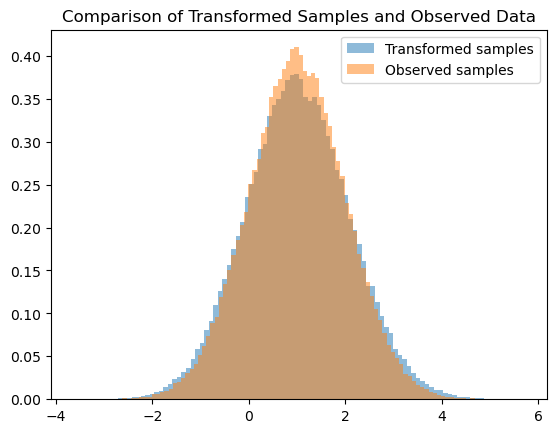

In [11]:
spline_transform_u0 = T.spline(input_dim=1, 
                            count_bins=16,
                            bound=100, # this is important to understand a priori what is the bound of X which is [0, 2pi ~ 6.28] 
                            order='linear') # this transform doesn't work

flow_dist_u0 = dist.TransformedDistribution(eps_u0_distribution, [spline_transform_u0])

steps = 2000

U0 = torch.tensor(U0, dtype=torch.float).unsqueeze(-1)
optimizer = torch.optim.Adam(spline_transform_u0.parameters(), lr=1e-2) # spline transform from T.Spline

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_u0.log_prob(U0).mean() # nll
    loss.backward()
    optimizer.step()
    flow_dist_u0.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


# Apply the learned spline transform to the samples
U0_transformed = spline_transform_u0(epsilon_u0.unsqueeze(-1))

# Plot the transformed samples
plt.hist(U0_transformed.detach().numpy().squeeze(), bins=100, density=True, alpha=0.5, label='Transformed samples')

# Plot the actual observed data
plt.hist(U0.detach().numpy().squeeze(), bins=100, density=True, alpha=0.5, label='Observed samples')

plt.title('Comparison of Transformed Samples and Observed Data')
plt.legend()
plt.show()

Now let's do similar for $U_1 \coloneqq U_0 \left(1+\epsilon_{u_1}\right), \text{ } \epsilon_{u_1} \sim \mathcal{N}(0,1)$

torch.Size([100000, 1])


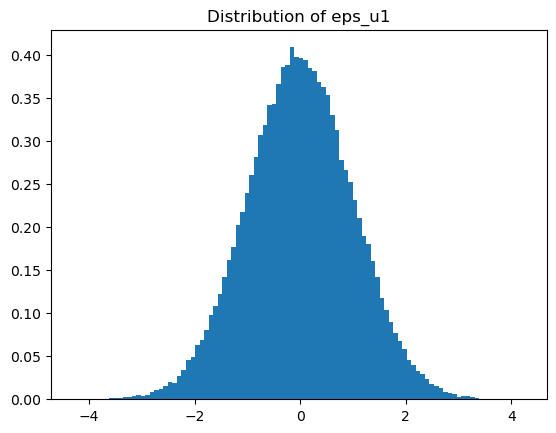

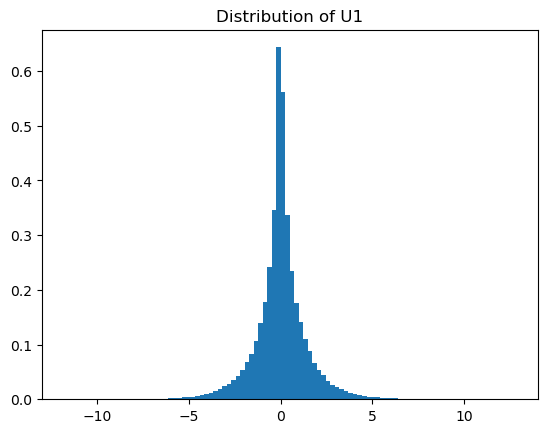

In [12]:
eps_u1_distribution = dist.Normal(torch.zeros(1), torch.ones(1))

# Generate 10000 samples from the normal distribution
epsilon_u1 = eps_u1_distribution.sample(torch.Size([100000]))

# Generate observations of U0 with ground-truth mechanism
U1 = epsilon_u0 * (1+epsilon_u1)
print(U1.shape)

# Plot histogram
plt.hist(epsilon_u1.numpy(), bins=100, density=True)
plt.title('Distribution of eps_u1')
plt.show()

plt.hist(U1.numpy(), bins=100, density=True)
plt.title('Distribution of U1')
plt.show()


step: 0, loss: 529.036865234375


/var/folders/d7/661_pryx1zx9ctp4z8417_d80000gn/T/ipykernel_87014/1765245232.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U1 = torch.tensor(U1, dtype=torch.float).unsqueeze(-1)


step: 200, loss: 1.651771903038025
step: 400, loss: 1.6362439393997192
step: 600, loss: 1.631091594696045
step: 800, loss: 1.6274802684783936
step: 1000, loss: 1.6254087686538696
step: 1200, loss: 1.6243975162506104
step: 1400, loss: 1.6239172220230103
step: 1600, loss: 1.623661994934082
step: 1800, loss: 1.6234955787658691


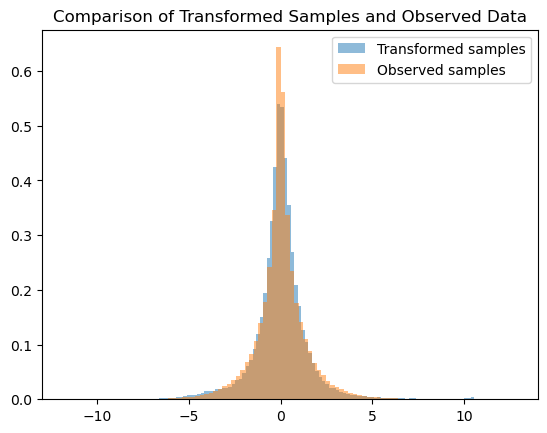

In [13]:
spline_transform_u1 = T.spline(input_dim=1, 
                            count_bins=16,
                            bound=100, # this is important to understand a priori what is the bound of X which is [0, 2pi ~ 6.28] 
                            order='linear') # this transform doesn't work

flow_dist_u1 = dist.TransformedDistribution(eps_u1_distribution, [spline_transform_u1])

steps = 2000

U1 = torch.tensor(U1, dtype=torch.float).unsqueeze(-1)
optimizer = torch.optim.Adam(spline_transform_u1.parameters(), lr=1e-2) # spline transform from T.Spline

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist_u1.log_prob(U1).mean() # nll
    loss.backward()
    optimizer.step()
    flow_dist_u1.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


# Apply the learned spline transform to the samples
U1_transformed = spline_transform_u1(epsilon_u1.unsqueeze(-1))

# Plot the transformed samples
plt.hist(U1_transformed.detach().numpy().squeeze(), bins=100, density=True, alpha=0.5, label='Transformed samples')

# Plot the actual observed data
plt.hist(U1.detach().numpy().squeeze(), bins=100, density=True, alpha=0.5, label='Observed samples')

plt.title('Comparison of Transformed Samples and Observed Data')
plt.legend()
plt.show()

Now, let's recall how our DGP is defined:

\begin{align*}
X &\coloneqq \epsilon_x \mod 2\pi, \text{ } \epsilon_x \sim \operatorname{N}(0,1)\\
U_0  &\coloneqq 1 +\epsilon_{u_0}, \text{ } \epsilon_{u_0} \sim \mathcal{N}(0,1) \\
U_1  &\coloneqq U_0 \left(1+\epsilon_{u_1}\right), \text{ } \epsilon_{u_1} \sim \mathcal{N}(0,1) \\
V_0 &\coloneqq U_0\sin(X), \text{ } \\
V_1 &\coloneqq U_1\cos(X) \text{ } \\
\end{align*}

Then this can be representeda as a graph as follows: 

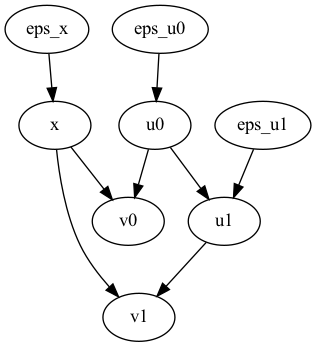

In [14]:
import pygraphviz as pgv
from IPython.display import Image

# Create a new directed graph
G = pgv.AGraph(directed=True)

# Add nodes
nodes = ['eps_x', 'eps_u0', 'eps_u1', 'x', 'u0', 'u1', 'v0', 'v1']
for node in nodes:
    G.add_node(node)

# Add edges
edges = [('eps_x', 'x'), ('eps_u0', 'u0'), ('eps_u1', 'u1'), 
         ('x', 'v0'), ('x', 'v1'), ('u0', 'v0'), ('u0', 'u1'), ('u1', 'v1')]
for edge in edges:
    G.add_edge(edge[0], edge[1])

# Render the graph
G.layout(prog='dot')

# Save temporary .png image and display it
G.draw('temp_graph.png')
Image(filename='temp_graph.png')

Now, let's recall the data generating process of our example:

\begin{align*}
X &\coloneqq \epsilon_x \mod 2\pi, \text{ } \epsilon_x \sim \operatorname{N}(0,1)\\
U_0  &\coloneqq 1 +\epsilon_{u_0}, \text{ } \epsilon_{u_0} \sim \mathcal{N}(0,1) \\
U_1  &\coloneqq U_0 \left(1+\epsilon_{u_1}\right), \text{ } \epsilon_{u_1} \sim \mathcal{N}(0,1) \\
V_0 &\coloneqq U_0\sin(X), \text{ } \\
V_1 &\coloneqq U_1\cos(X), \text{ } \\
\end{align*}

If we observe $x$ which is not on the major/minor axes (i.e. $x \mod \pi \neq 0$) and $v=(v_0, v_1)$ , then $u=(u_0, u_1)$ is deterministically found which means we can infer the length of mjaor/minor axis of elipse. Given that, we can ***identify*** the counterfactual query $V_{x^{\prime}} \mid\{X=x, V=(v_0, v_1)\}$ by simply plugging in the value of $x^{\prime}$ into the formula of equation given $u=(u_0, u_1)$. 

For instance, when I observe $x=\pi/4$, one can infer that $\epsilon_x=\pi/4$ which means we need to update the distribution of $\epsilon_x|x$ to be a point mass distribution, i.e. $\operatorname{P}(\epsilon_x=\pi/4)=1 \leftarrow \operatorname{P(\epsilon_x|x=0)}$. In addition, if we've also observed $v=(v_0=\frac{3\sqrt{2}}{2}, v_1=\frac{\sqrt{2}}{2})$, we can infer that $u_0 = \frac{v_0}{\sin(x)} = \frac{6}{2}=3$ and $u_1 = \frac{v_1}{\cos(x)}=\frac{3}{3}=1$. For $u_0$ and $u_1$ to be such values, $\epsilon_{u_0}$ and $\epsilon_{u_1}$ should be also uniquely determined to be a point mass at $2$ and $-\frac{2}{3}$ respectively. This updates the distribution of $U_0$ and $U_1$ as well to be point-mass at $3$ and $1$ respectively. Over this new distribution, we can intervene on different values of $x$ so that we can estimate the counterfactual query, which makes the entire ellipse we've drawn above.

So now we assume that we don't have an access to such true data-generating process and formulas but we want to check whether the above normalizing flows can capture the true data-generating process.

In [22]:
# Assuming you have your trained spline_transform from the above code snippet

# Observe X=pi/4
observed_X = torch.tensor([np.pi/4]).unsqueeze(-1)

# Apply the inverted transform to the observed data
epsilon_x_inferred = spline_transform.inv(observed_X)

print('Inferred epsilon_x:', epsilon_x_inferred.item())

Inferred epsilon_x: -0.573233425617218


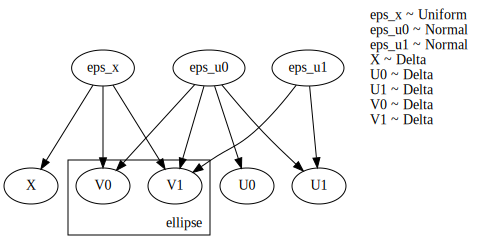

In [66]:
import pyro
import numpy as np

def model():
        eps_x = pyro.sample("eps_x", pyro.distributions.Uniform(0, 2*np.pi))
        eps_u0 = pyro.sample("eps_u0", pyro.distributions.Normal(0, 1))
        eps_u1 = pyro.sample("eps_u1", pyro.distributions.Normal(0, 1))

        x = pyro.sample("X", pyro.distributions.Delta(eps_x))
        u0 = pyro.sample("U0", pyro.distributions.Delta(1 + eps_u0))
        u1 = pyro.sample("U1", pyro.distributions.Delta(u0 * (1 + eps_u1)))
    
        with pyro.plate("ellipse", size=1000):
            v0 = pyro.sample("V0", pyro.distributions.Delta(u0 * (2 + np.sin(x))))
            v1 = pyro.sample("V1", pyro.distributions.Delta(u1 * (2 + np.cos(x))))
            return (v0, v1)

pyro.render_model(model, model_args=(), render_distributions=True, render_params=True)

So in this example, when we observe $x$ and $v=(v_0, v_1)$, $u=(u_0, u_1)$ is deterministically defined which means we can ***identify*** the counterfactual query $V_{x^{\prime}} \mid\{X=x, V=(v_0, v_1)\}$ by simply plugging in the value of $x^{\prime}$ into the equation. 

For example, when I observe $x=0$, one can infer that $\epsilon_x=0$ which means we need to update distribution of $\epsilon_x|x$ to be a point mass at $0$, i.e. $\operatorname{P}(\epsilon_x) \leftarrow \operatorname{P(\epsilon_x|x=0)}$. In addition, if we also have observed $v=(v_0=6, v_1=3)$, we can infer that $u_0 = \frac{v_0}{2+\sin(x)} = \frac{6}{2}=3$ and $u_1 = \frac{v_1}{2+\cos(x)}=\frac{3}{3}=1$. Then $\epsilon_{u_0}$ and $\epsilon_{u_1}$ is also uniquely determined and we can update the distribution of $\epsilon_{u_0}$ and $\epsilon_{u_1}$ to be a point mass at $2$ and $-\frac{2}{3}$. Over this new distribution, we can intervene on different values of $x$ so that we can estimate the counterfactual query, which makes the ellipse we've drawn above with python. 

In [85]:
# Observe X=0
observed_X = torch.tensor([0.]).unsqueeze(-1)

# Apply the inverted transform to the observed data
epsilon_x_inferred = spline_transform.inv(observed_X)

print('Inferred epsilon_x:', epsilon_x_inferred.item())

Inferred epsilon_x: -3.073659896850586


Let's do similar for the mechanism of $U_0  \coloneqq 1 +\epsilon_{u_0}, \text{ } \epsilon_{u_0} \sim \mathcal{N}(0,1)$

In [38]:
import numpy as np

# Define the number of samples
n_samples = 10000

# Draw samples from the normal distribution
epsilon_x = np.random.uniform(0, 2*np.pi, n_samples)
epsilon_u0 = np.random.normal(0, 1, n_samples)
epsilon_u1 = np.random.normal(0, 1, n_samples)

# Compute X, U0, U1
X = epsilon_x
U0 = 1 + epsilon_u0
U1 = U0 * (1 + epsilon_u1)

# Compute V0, V1
V0 = U0 * (2 + np.sin(X))
V1 = U1 * (2 + np.cos(X))

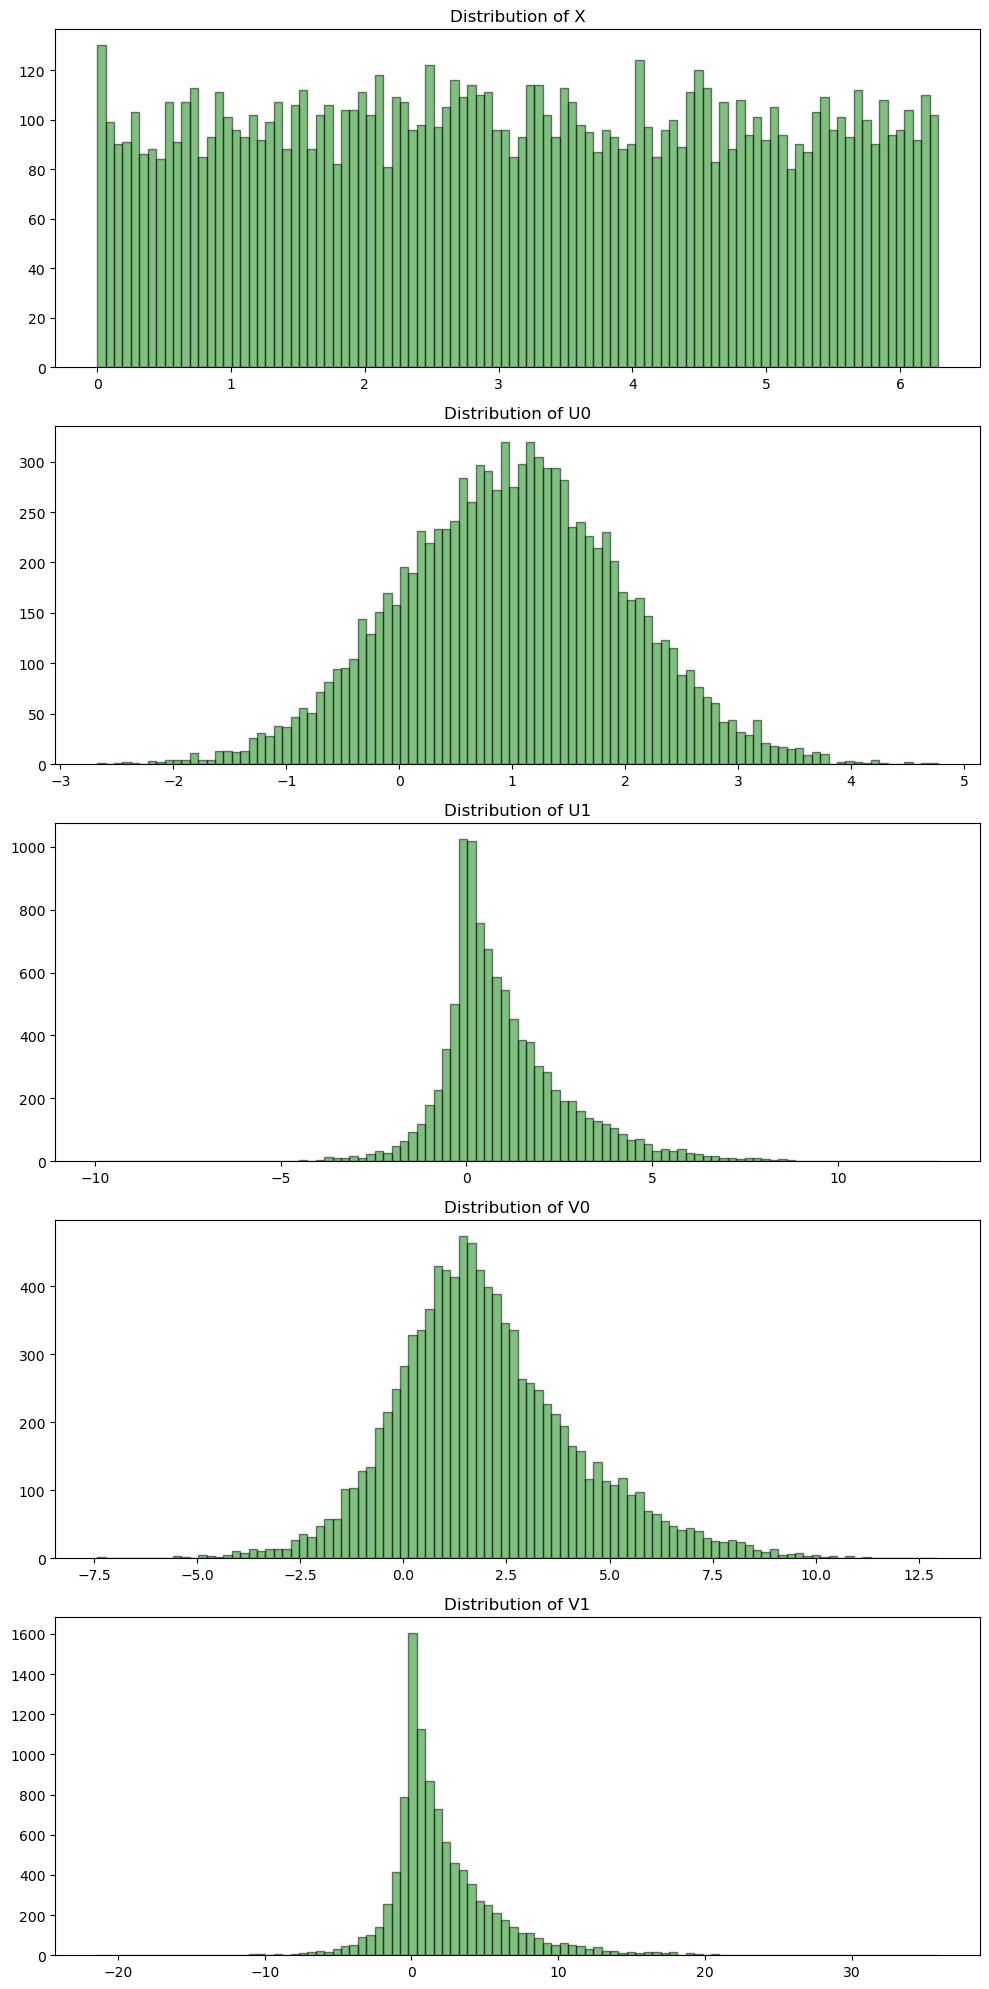

In [39]:
import matplotlib.pyplot as plt

# Create a list of variable names and corresponding data
variables = [("X", X), ("U0", U0), ("U1", U1), ("V0", V0), ("V1", V1)]

# Create a figure and set of subplots
fig, axs = plt.subplots(len(variables), 1, figsize=(10, 20))

# Create a histogram for each variable
for i, (var_name, var_data) in enumerate(variables):
    axs[i].hist(var_data, bins=100, alpha=0.5, color='g', edgecolor='black')
    axs[i].set_title(f'Distribution of {var_name}')

# Add space between plots
plt.tight_layout()

# Show the plots
plt.show()

So in this example, when we observe $x$ and $v=(v_0, v_1)$, $u=(u_0, u_1)$ is deterministically defined which means we can ***identify*** the counterfactual query $V_{x^{\prime}} \mid\{X=x, V=(v_0, v_1)\}$ by simply plugging in the value of $x^{\prime}$ into the equation. 

For example, when I observe $x=0$, one can infer that $\epsilon_x=0$ which means we need to update distribution of $\epsilon_x|x$ to be a point mass at $0$, i.e. $\operatorname{P}(\epsilon_x) \leftarrow \operatorname{P(\epsilon_x|x=0)}$. In addition, if we also have observed $v=(v_0=6, v_1=3)$, we can infer that $u_0 = \frac{v_0}{2+\sin(x)} = \frac{6}{2}=3$ and $u_1 = \frac{v_1}{2+\cos(x)}=\frac{3}{3}=1$. Then $\epsilon_{u_0}$ and $\epsilon_{u_1}$ is also uniquely determined and we can update the distribution of $\epsilon_{u_0}$ and $\epsilon_{u_1}$ to be a point mass at $2$ and $-\frac{2}{3}$. Over this new distribution, we can intervene on different values of $x$ so that we can estimate the counterfactual query, which makes the ellipse we've drawn above with python. 

Our goal is to come up with an algorithm to ***learn*** this data generation process - but what do we mean by ***learning*** in this context? 

We assume that we have an only exccess to the (realized/observed) data generated from the above process but we assume we know the exogenous distributions and DAG.

# Problem Setup

To enhance the practicality of this example, we assume knowledge of the causal diagram G that might
include *unobserved confounders*, so Markovianity assumption does not hold but we have an access to observational data distribution ($\mathcal{L_1}$). Given this, we are interested in learning the data generation mechanisms $\mathcal{F}$, which can be further used to query the counterfactual distribution ($\mathcal{L_3}$). 

As well-postulated in *fundamental limitation of causal inference* and *Pearl's Hierarchy*, cross-layer
inference is not possible in general settings, and we need to make further assumptions.

# Bijective Generation Mechanism

To make the problem tractable, we assume that the data generation mechanism $\mathcal{F}$ is bijective, which means that we can invert the function to get the inverse mapping $\mathcal{F}^{-1}$. This assumption is not too restrictive, as we can always use a bijective function to transform the data to a new space, and learn the distribution in the new space.

According to *"Counterfactual Idenfiability of Bijective Causal Models (Nasr-Esfahany et al., 2023)"*, we can establish counterfactual identifiability from observational $\left(\mathcal{L}_1\right)$ data in the **presence of latent confounding** when there exists a set of variables $(\boldsymbol{Z})$ that satisfy the backdoor criterion (BC) with respect to $(\boldsymbol{X}, V)$, i.e., if $\boldsymbol{Z}$ blocks every path between $\boldsymbol{X}$ and $V$ that contains an arrow into $\boldsymbol{X}{ }$.

# Data Generation

Distributions of random variables are defined as follows:

\begin{align*}
X &\coloneqq \epsilon_x \bmod 2\pi, \epsilon_x \sim \mathcal{N}(0,1)\\

\end{align*}

\begin{align*}
& U_0:=e^{1.64985274 z+0.2656131}+\epsilon_{u_0}, \epsilon_{u_0} \sim \operatorname{Beta}(1,1) \\
& U_1:=U_0\left(1+\epsilon_{u_1} e^{1.61323358 z-0.18070237}\right), \epsilon_{u_1} \sim \operatorname{Exponential}(1)
\end{align*}
<!-- Z &\coloneqq \epsilon_z \sim \mathcal{N}(0,1)\\ -->


\begin{align*}
& U_0:=e^{1.64985274 z+0.2656131}+\epsilon_{u_0}, \epsilon_{u_0} \sim \operatorname{Beta}(1,1) \\
& U_1:=U_0\left(1+\epsilon_{u_1} e^{1.61323358 z-0.18070237}\right), \epsilon_{u_1} \sim \operatorname{Exponential}(1)
\end{align*}